# Unsupervised learning - K-means application
Goal of the excercise is to learn how to use K-means implementation in the Scikit-learn library to perform clustering and subsequent cluster analysis on a Titanic dataset.

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Dictionary

|Variable|Definition|Key|
|:-------|:-------|:--------|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

### Load titanic dataset

In [ ]:
df = pd.read_csv('titanic.csv', index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### How many missing values are in there?

In [ ]:
df.shape

(891, 11)

In [ ]:
df.isna().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Survived      0
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Fare          0
dtype: int64

## We are going to cluster the passangers into defined number of groups
- It is clear that it is mandatory to select only a relevant subset of features and encode the categorical features as in the classification task performed in one of the previous lectures

In [ ]:
df_clustering = df[['Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].copy()
df_clustering = df_clustering.dropna()
df_clustering.Sex = df_clustering.Sex.astype(str)
df_clustering.Embarked = df_clustering.Embarked.astype(str)
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [ ]:
df_clustering.shape

(712, 8)

In [ ]:
df_clustering.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [ ]:
df_clustering

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,3,female,39.0,0,5,29.1250,Q
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S


In [ ]:
df_clustering.describe(include=np.number)

,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


include=np.number jenom číselné hodnoty

### Lets encode categorical features
- https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
- https://scikit-learn.org/stable/modules/classes.html?highlight=preprocessing#module-sklearn.preprocessing

We will use the same encoding methodology as in the classification lecture.

In [ ]:
enc = sklearn.preprocessing.OrdinalEncoder()
enc.fit_transform(df_clustering[['Sex']])[:20]

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]])

In [ ]:
enc.categories_

[array(['female', 'male'], dtype=object)]

In [ ]:
enc = sklearn.preprocessing.OneHotEncoder(sparse=False)
enc.fit_transform(df_clustering[['Embarked']])

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
enc.categories_

[array(['C', 'Q', 'S'], dtype=object)]

In [ ]:
pd.get_dummies(df_clustering[['Embarked']]).head()

,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1
5,0,0,1


In [ ]:
df_encoded = pd.DataFrame(index = df_clustering.index)

In [ ]:
df_encoded['Sex'] = sklearn.preprocessing.OrdinalEncoder().fit_transform(df_clustering[['Sex']])

In [ ]:
df_encoded = df_encoded.join(pd.get_dummies(df_clustering[['Embarked']]))
df_encoded.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,
1,1.0,0,0,1
2,0.0,1,0,0
3,0.0,0,0,1
4,0.0,0,0,1
5,1.0,0,0,1


### It is important to select the appropriate scaling method of the number features
- There are many ways how to do this - MinMax, StandardScaler, PowerTransform, ...
- This step heavily depends on a domain knowledge because the scales of the features have significant effect on a distances between couples of dataset instances
    - It is clear that if one variable is in range (0,1) and the second one is in a range (5000, 10 000), the difference in the second feature will be definitely more important than in the  first one from the numerical point of view
    - Although it is possible that from the domain point of view the first variable may be more important
    - Thus it is a good idea to at least transform the features into a simiiar scales so the effect on the distance value would be similiar
    - Transformation depends heavily on the statistical distribution of the feature
        - You can use PowerTransform for a heavy-tailed distribution, Standardization or MinMax normalization for normally distributed features etc.

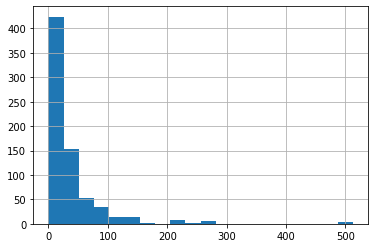

In [ ]:
df_clustering.Fare.hist(bins=20)

In [ ]:
df_clustering.Fare.describe()

count    712.000000
mean      34.567251
std       52.938648
min        0.000000
25%        8.050000
50%       15.645850
75%       33.000000
max      512.329200
Name: Fare, dtype: float64

In [ ]:
enc = sklearn.preprocessing.PowerTransformer()
enc.fit_transform(df_clustering[['Fare']])[:20]

array([[-0.99765031],
       [ 1.28775742],
       [-0.90107255],
       [ 1.02427568],
       [-0.88411158],
       [ 1.00273178],
       [ 0.13202717],
       [-0.53475875],
       [ 0.48661962],
       [-0.10705645],
       [ 0.36394683],
       [-0.88411158],
       [ 0.52494282],
       [-0.91080102],
       [-0.15160295],
       [ 0.45530075],
       [-0.029469  ],
       [ 0.34315814],
       [-0.36978947],
       [-0.88691511]])

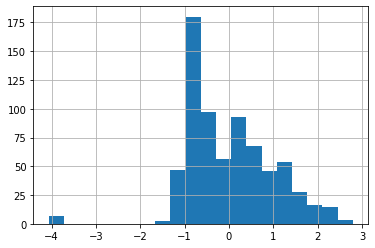

In [ ]:
df_encoded['Fare'] = sklearn.preprocessing.PowerTransformer().fit_transform(df_clustering[['Fare']])
df_encoded.Fare.hist(bins=20)

In [ ]:
df_encoded.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare
PassengerId,,,,,
1,1.0,0,0,1,-0.997650
2,0.0,1,0,0,1.287757
3,0.0,0,0,1,-0.901073
4,0.0,0,0,1,1.024276
5,1.0,0,0,1,-0.884112


In [ ]:
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [ ]:
df_encoded['Age'] = sklearn.preprocessing.minmax_scale(df_clustering.Age)

In [ ]:
df_encoded = df_encoded.join(df_clustering[['Survived', 'Pclass', 'SibSp', 'Parch']])
df_encoded.head()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare,Age,Survived,Pclass,SibSp,Parch
PassengerId,,,,,,,,,,
1,1.0,0,0,1,-0.997650,0.271174,0,3,1,0
2,0.0,1,0,0,1.287757,0.472229,1,1,1,0
3,0.0,0,0,1,-0.901073,0.321438,1,3,0,0
4,0.0,0,0,1,1.024276,0.434531,1,1,1,0
5,1.0,0,0,1,-0.884112,0.434531,0,3,0,0


#### Check our preprocessed data by describe data

In [ ]:
df_encoded.describe()

,Sex,Embarked_C,Embarked_Q,Embarked_S,Fare,Age,Survived,Pclass,SibSp,Parch
count,712.000000,712.000000,712.000000,712.000000,7.120000e+02,712.000000,712.000000,712.000000,712.000000,712.000000
mean,0.636236,0.182584,0.039326,0.778090,7.484650e-17,0.367204,0.404494,2.240169,0.514045,0.432584
std,0.481420,0.386597,0.194506,0.415823,1.000703e+00,0.182118,0.491139,0.836854,0.930692,0.854181
min,0.000000,0.000000,0.000000,0.000000,-4.068874e+00,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,-8.841116e-01,0.246042,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,-1.749735e-01,0.346569,0.000000,2.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,5.770630e-01,0.472229,1.000000,3.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,2.796651e+00,1.000000,1.000000,3.000000,5.000000,6.000000


## Clustering

Use **Elbow method** to identify potentially ideal number of clusters in our data in **KMeans** algorithm.

There are two basic methods for evaluation of clusters quality:
1. SSE - Sum of squared distances of samples to their closest cluster center, this one is specific for **KMeans** algorithm. You can find it as **inertia_** attribute of KMeans sklearn object.
2. Silhouette Coefficient - calculated using the mean intra-cluster distance and the mean nearest-cluster distance

We ussually want to find number of clusters with low SSE and high Silhoutte coef.

- Take a look at [this](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c) and [this](https://towardsdatascience.com/k-means-clustering-from-a-to-z-f6242a314e9a)

#### Try different number of clusters from range <2, 10> for KMeans algorithm, save both evaluation criteria and plot dependency of criteria to number of clusters.

In [ ]:
X = df_encoded.values

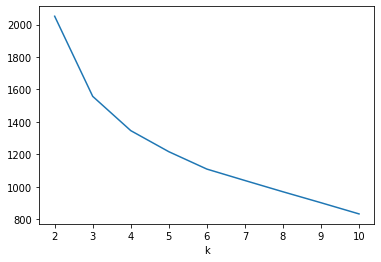

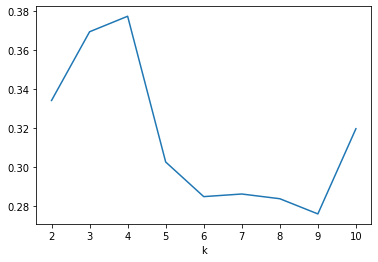

In [ ]:
clustering_scores = []
for k in range(2, 11):
    clustering = sklearn.cluster.KMeans(n_clusters=k,random_state=13).fit(X)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(X, clustering.labels_)
    })
df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')
df_clustering_scores.sse.plot()
plt.figure()
df_clustering_scores.silhouette.plot()

In [ ]:
clustering = sklearn.cluster.KMeans(n_clusters=4,random_state=13)
clustering.fit(X)

KMeans(n_clusters=4, random_state=13)

#### How big are our clusters? How many 0, 1, .. are in vector?

In [ ]:
pd.Series(clustering.labels_).value_counts()

1    398
3    182
2     97
0     35
dtype: int64

## Explore clusters
Try to use cluster information and exploration analysis of our data.

In [ ]:
df_clustering['cluster_id'] = clustering.labels_
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cluster_id
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,1
2,1,1,female,38.0,1,0,71.2833,C,3
3,1,3,female,26.0,0,0,7.9250,S,1
4,1,1,female,35.0,1,0,53.1000,S,3
5,0,3,male,35.0,0,0,8.0500,S,1


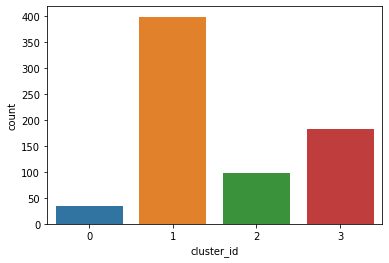

In [ ]:
sns.countplot(data=df_clustering, x='cluster_id')

#### Use groupby function to cluster_id and decribe function for both numerical and categorical features

In [ ]:
with pd.option_context('display.max_columns', None):
    display(df_clustering.groupby('cluster_id').describe())

Survived                                              Pclass  \
              count      mean       std  min  25%  50%  75%  max  count   
cluster_id                                                                
0              35.0  0.200000  0.405840  0.0  0.0  0.0  0.0  1.0   35.0   
1             398.0  0.246231  0.431357  0.0  0.0  0.0  0.0  1.0  398.0   
2              97.0  0.690722  0.464597  0.0  0.0  1.0  1.0  1.0   97.0   
3             182.0  0.637363  0.482088  0.0  0.0  1.0  1.0  1.0  182.0   

                                                           Age             \
                mean       std  min  25%  50%  75%  max  count       mean   
cluster_id                                                                  
0           2.800000  0.584103  1.0  3.0  3.0  3.0  3.0   35.0   9.857143   
1           2.723618  0.469734  1.0  2.0  3.0  3.0  3.0  398.0  28.953317   
2           2.164948  0.687393  1.0  2.0  2.0  3.0  3.0   97.0  22.853093   
3           1.115385  0.320367  1.0  1.0  1.0  1.0  2.0  182.0  38.571429   

                                                        SibSp            \
                  std    min   25%   50%     75%   max  count      mean   
cluster_id                                                                
0            8.203811   1.00   3.5   8.0  14.000  33.0   35.0  3.800000   
1           11.769346   0.42  21.0  27.0  34.875  74.0  398.0  0.188442   
2           15.959488   0.67   7.0  24.0  36.000  64.0   97.0  0.762887   
3           13.853829  14.00  28.0  36.5  49.000  80.0  182.0  0.461538   

                                               Parch                           \
                 std  min  25%  50%  75%  max  count      mean       std  min   
cluster_id                                                                      
0           0.677365  3.0  3.0  4.0  4.0  5.0   35.0  1.542857  0.610827  0.0   
1           0.434260  0.0  0.0  0.0  0.0  2.0  398.0  0.072864  0.260241  0.0   
2           0.657856  0.0  0.0  1.0  1.0  2.0   97.0  1.938144  1.116304  1.0   
3           0.562310  0.0  0.0  0.0  1.0  2.0  182.0  0.203297  0.442731  0.0   

                                 Fare                                          \
            25%  50%  75%  max  count       mean        std      min      25%   
cluster_id                                                                      
0           1.0  2.0  2.0  2.0   35.0  51.673571  66.280456   7.9250  27.9000   
1           0.0  0.0  0.0  1.0  398.0  11.024570   6.510430   0.0000   7.7958   
2           1.0  2.0  2.0  6.0   97.0  45.400687  51.028040  11.1333  20.5750   
3           0.0  0.0  0.0  2.0  182.0  76.987157  74.577792  24.0000  30.0708   

                                         
                50%       75%       max  
cluster_id                               
0           31.2750  39.68750  263.0000  
1            8.6625  13.00000   56.4958  
2           27.0000  39.00000  263.0000  
3           56.9646  85.74375  512.3292

In [ ]:
with pd.option_context('display.max_columns', None):
    display(df_clustering.groupby('cluster_id').describe(include='O'))

Sex                     Embarked                
           count unique     top freq    count unique top freq
cluster_id                                                   
0             35      2    male   20       35      2   S   31
1            398      2    male  302      398      3   S  337
2             97      2  female   67       97      3   S   83
3            182      2    male  101      182      3   S  103

#### What can we see from previous tables?

## Create additional plots showing value of different attributes based on cluster group

- Is Fare different for points in different clusters?
- Is Age different for point in different clusters?
- Does number of suvival differ in clusters?
- Does number of passanger of each class differ in clusters?

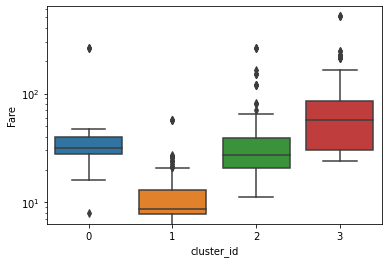

In [ ]:
sns.boxplot(data=df_clustering, y='Fare', x='cluster_id')
plt.yscale('log')

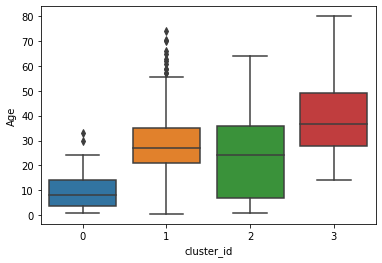

In [ ]:
sns.boxplot(data=df_clustering, y='Age', x='cluster_id')

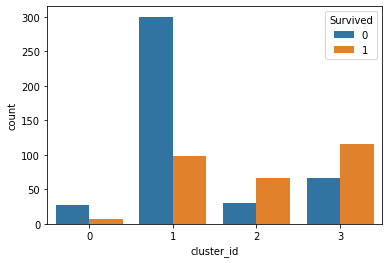

In [ ]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Survived')

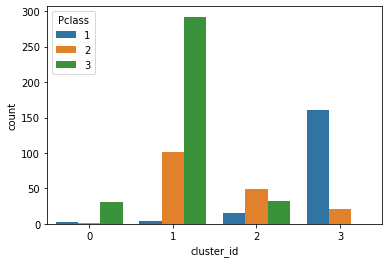

In [ ]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Pclass')

#### Write a textual description of clusters

# Is our data represented in the best way?

Clustering methods depends on calculation of distance metric among data points in our data matrix.

Therefore it is necessary to preproces our data matrix **X** in a best way possible to achive equal distance for every dataset feature. After such transformation we can count, that difference in age has same impact as difference in ticket class. Generally, it is very hard to create perfect tranformation for our real dataset.

#### Use StandardScaler transformation for our data **X**

In [ ]:
col_names = ['Fare', 'Age', 'SibSp', 'Parch']
enc = sklearn.preprocessing.StandardScaler()
X_stand = pd.DataFrame(enc.fit_transform(df_clustering.loc[:, col_names]), columns = col_names, index=df_clustering.index)
X_stand = pd.concat([X_stand, df_encoded.loc[:, ['Sex', 'Embarked_C', 'Embarked_Q', 'Embarked_S']], df_clustering.Survived], axis=1)

In [ ]:
X_stand

,Fare,Age,SibSp,Parch,Sex,Embarked_C,Embarked_Q,Embarked_S,Survived
PassengerId,,,,,,,,,
1,-0.516380,-0.527669,0.522511,-0.506787,1.0,0,0,1,0
2,0.694046,0.577094,0.522511,-0.506787,0.0,1,0,0,1
3,-0.503620,-0.251478,-0.552714,-0.506787,0.0,0,0,1,1
4,0.350326,0.369951,0.522511,-0.506787,0.0,0,0,1,1
5,-0.501257,0.369951,-0.552714,-0.506787,1.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
886,-0.102875,0.646142,-0.552714,5.350885,0.0,0,1,0,0
887,-0.407687,-0.182430,-0.552714,-0.506787,1.0,0,0,1,0
888,-0.086335,-0.734812,-0.552714,-0.506787,0.0,0,0,1,1


In [ ]:
X_stand.describe()

,Fare,Age,SibSp,Parch,Sex,Embarked_C,Embarked_Q,Embarked_S,Survived
count,7.120000e+02,7.120000e+02,7.120000e+02,7.120000e+02,712.000000,712.000000,712.000000,712.000000,712.000000
mean,-6.736185e-17,2.943962e-16,-1.496930e-17,1.496930e-17,0.636236,0.182584,0.039326,0.778090,0.404494
std,1.000703e+00,1.000703e+00,1.000703e+00,1.000703e+00,0.481420,0.386597,0.194506,0.415823,0.491139
min,-6.534272e-01,-2.017717e+00,-5.527137e-01,-5.067874e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.012575e-01,-6.657639e-01,-5.527137e-01,-5.067874e-01,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-3.576726e-01,-1.133826e-01,-5.527137e-01,-5.067874e-01,1.000000,0.000000,0.000000,1.000000,0.000000
75%,-2.962586e-02,5.770939e-01,5.225108e-01,6.647471e-01,1.000000,0.000000,0.000000,1.000000,1.000000
max,9.031168e+00,3.477095e+00,4.823409e+00,6.522419e+00,1.000000,1.000000,1.000000,1.000000,1.000000


# Task (2p)
- Use **KMeans** to differently preprocessed data matrix **X_stand**
- Detect "ideal" number of clusters using Elbow method
- Explore detected clusters and **describe** them to the Markdown cell


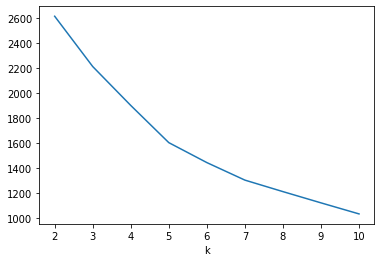

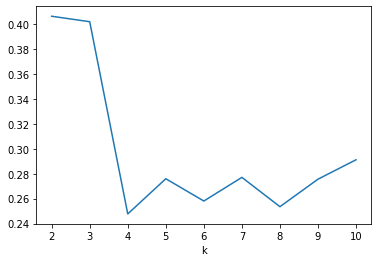

In [ ]:
clustering_scores = []
for k in range(2, 11):
    clustering = sklearn.cluster.KMeans(n_clusters=k).fit(X_stand)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(X_stand, clustering.labels_)
    })
df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')
df_clustering_scores.sse.plot()
plt.figure()
df_clustering_scores.silhouette.plot()

In [ ]:
clustering = sklearn.cluster.KMeans(n_clusters=5)
clustering.fit(X_stand)

KMeans(n_clusters=5)

In [ ]:
pd.Series(clustering.labels_).value_counts()

2    376
0    170
4    114
3     32
1     20
dtype: int64

In [ ]:
df_clustering['cluster_id'] = clustering.labels_
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cluster_id
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,2
2,1,1,female,38.0,1,0,71.2833,C,0
3,1,3,female,26.0,0,0,7.9250,S,2
4,1,1,female,35.0,1,0,53.1000,S,0
5,0,3,male,35.0,0,0,8.0500,S,2


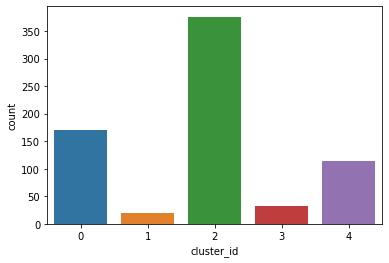

In [ ]:
sns.countplot(data=df_clustering, x='cluster_id')

Největší zastoupení má cluster 2, nejméně cluster 1

In [ ]:
with pd.option_context('display.max_columns', None):
    display(df_clustering.groupby('cluster_id').describe())

Survived                                              Pclass  \
              count      mean       std  min  25%  50%  75%  max  count   
cluster_id                                                                
0             170.0  0.429412  0.496455  0.0  0.0  0.0  1.0  1.0  170.0   
1              20.0  0.800000  0.410391  0.0  1.0  1.0  1.0  1.0   20.0   
2             376.0  0.313830  0.464666  0.0  0.0  0.0  1.0  1.0  376.0   
3              32.0  0.156250  0.368902  0.0  0.0  0.0  0.0  1.0   32.0   
4             114.0  0.666667  0.473486  0.0  0.0  1.0  1.0  1.0  114.0   

                                                           Age             \
                mean       std  min  25%  50%  75%  max  count       mean   
cluster_id                                                                  
0           1.658824  0.822076  1.0  1.0  1.0  2.0  3.0  170.0  48.544118   
1           1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   20.0  31.850000   
2           2.484043  0.719081  1.0  2.0  3.0  3.0  3.0  376.0  25.929521   
3           2.968750  0.176777  2.0  3.0  3.0  3.0  3.0   32.0   8.718750   
4           2.315789  0.732504  1.0  2.0  2.0  3.0  3.0  114.0  19.185702   

                                                        SibSp            \
                  std    min   25%   50%     75%   max  count      mean   
cluster_id                                                                
0            9.400969  30.00  42.0  47.0  54.000  80.0  170.0  0.364706   
1           12.612755  15.00  22.5  30.0  39.000  64.0   20.0  0.800000   
2            6.422021   5.00  21.0  26.0  30.625  40.0  376.0  0.226064   
3            7.599806   1.00   3.0   7.5  11.000  33.0   32.0  3.875000   
4           13.836940   0.42   5.0  18.5  29.000  54.0  114.0  0.692982   

                                                Parch                      \
                 std  min  25%  50%   75%  max  count      mean       std   
cluster_id                                                                  
0           0.529532  0.0  0.0  0.0  1.00  2.0  170.0  0.188235  0.406868   
1           1.151658  0.0  0.0  0.0  1.25  3.0   20.0  1.200000  1.056309   
2           0.472679  0.0  0.0  0.0  0.00  2.0  376.0  0.010638  0.102729   
3           0.659912  3.0  3.0  4.0  4.00  5.0   32.0  1.500000  0.622171   
4           0.625805  0.0  0.0  1.0  1.00  2.0  114.0  1.754386  1.068962   

                                      Fare                                    \
            min  25%  50%  75%  max  count        mean         std       min   
cluster_id                                                                     
0           0.0  0.0  0.0  0.0  2.0  170.0   42.603384   37.320522    0.0000   
1           0.0  0.0  1.0  2.0  4.0   20.0  273.330005  107.246880  164.8667   
2           0.0  0.0  0.0  0.0  1.0  376.0   18.469657   21.847189    0.0000   
3           0.0  1.0  2.0  2.0  2.0   32.0   31.861719    9.552026    7.9250   
4           1.0  1.0  1.0  2.0  6.0  114.0   34.548611   30.920902    7.2292   

                                                      
                   25%       50%       75%       max  
cluster_id                                            
0            13.000000   26.5500   61.8292  153.4625  
1           211.459375  247.5208  263.0000  512.3292  
2             7.854200    9.5000   16.1000  151.5500  
3            27.900000   31.2750   39.6875   46.9000  
4            16.700000   26.0000   36.7500  151.5500

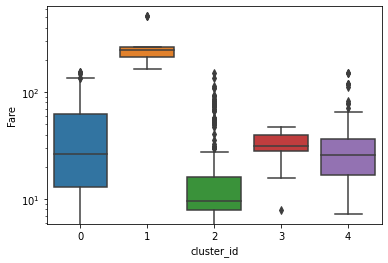

In [ ]:
sns.boxplot(data=df_clustering, y='Fare', x='cluster_id')
plt.yscale('log')

Nejvíce za lístek zaplatili v clusteru 1. Nejlevnější je dvojka, která má i nejvíce outlierů. Medián u 0,3 a 4 je podobný.

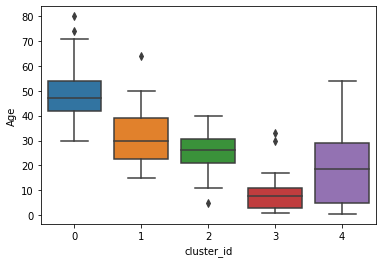

In [ ]:
sns.boxplot(data=df_clustering, y='Age', x='cluster_id')

Děti jsou hlavně v clusteru 3 ale také i ve 4, tam jsou i dospělí, proto zvedají median na cca 20let. Nejstarší cestující jsou v 0. 1 a 2 jsou si podobné

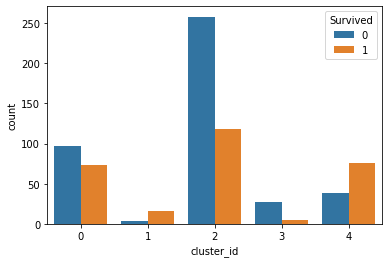

In [ ]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Survived')

Nejvíce u
úmrtí má cluster 2. Děti (3) vetšina zemřela. Dost přežilo starších lidí. Nejúspěšnější skupina kde většina přežila je 4, kde median byl 20 let.

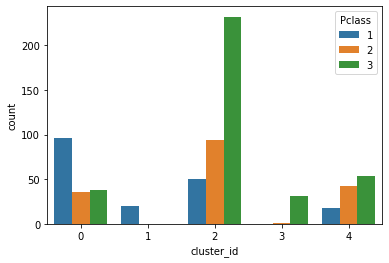

In [ ]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Pclass')

0 cluster: nejstarší cestující, proto největší zastoupení první trídy. 1: cluster jenom 1 první třída, median věku 30let nejdražší lístek. 2cluster: naprosto převažuje 3. třída. 3cluster: děti více méně jenom 3. třída.

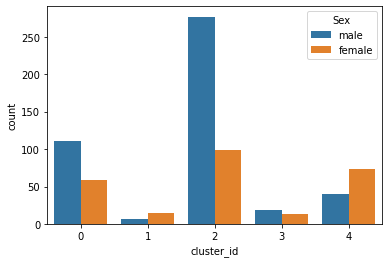

In [ ]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Sex')

Nejvíce mužů je ve dvojce, tam je také největší smrtnost. V 1 a 4 mají převahu ženy, v těchto skupinách většina přežila.

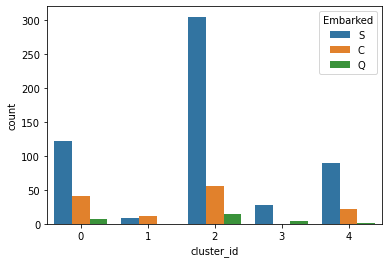

In [ ]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Embarked')

	C = Cherbourg, Q = Queenstown, S = Southampton